# Modeling

This notebook explores application of several clustering methods on the Washing, D.C. Census Tract and ACS data.

#### Considerations:
 - Look at heirarchical clutering, like Ward's clustering
 - Look at self-organizing map (SOM)
 - See soft classifiers like Fuzzy C-Means or Gustafson-Kessel algorithm, or m-logit

## Import Libraries and Read Data:

In [496]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture

import geopandas as gpd
import descartes
#! pip install geoplot
#import geoplot

In [497]:
# Read data:

df = pd.read_csv('../data/outputs/03_merged_clean_engineered.csv')

## Define X:

In [498]:
# Define:

X = df.drop(columns = ['name_x', 'geo_id', 'pop_density','Unnamed: 0'])

# pop_density seems to be causing issues in the model, based on below analysis.

In [499]:
X

,median_age,pct_hisp_latino,pct_black,pct_asian,pct_unemployed,avg_wrk_commute_mins,median_hsld_income,avg_household_size,pct_bach_degree,median_rent,pct_other_minority,pct_renter_occupied
0,41.3,14.6,0.7,6.2,1.8,24.2,191146,2.19,89.6,2289,0.0,0.376827
1,27.5,8.9,5.9,6.3,2.3,21.3,170987,2.26,90.5,2398,1.2,0.269978
2,31.5,6.6,7.3,7.4,2.0,25.3,152120,2.58,91.1,2056,0.0,0.480709
3,45.7,15.6,3.0,6.2,0.4,25.6,126731,2.27,82.0,2221,0.0,0.366667
4,34.8,16.6,4.1,2.3,1.7,27.7,116303,1.86,92.0,2134,0.0,0.707840
...,...,...,...,...,...,...,...,...,...,...,...,...
172,29.3,13.6,6.7,11.4,3.1,21.0,73688,1.48,83.1,2189,2.0,0.810606
173,19.9,8.7,10.0,12.4,3.1,15.9,45278,1.40,78.9,1764,0.1,0.683287
174,26.3,2.2,94.4,0.6,9.0,31.6,41660,2.63,18.3,1160,0.4,0.837649
175,44.0,6.7,27.0,5.5,3.8,28.8,84375,1.57,81.2,1809,0.6,0.418087


## Scale Data:

In [500]:
# Transform numeric data to Z-scores:

sc = StandardScaler()
X_sc = sc.fit_transform(X)

## Modeling:

The following lines model the ACS data using several techniques, including K-Means, DBSCAN, and Gaussian Mixtures.

### K-Means:

In [501]:
# Instantiate and fit K means:

km = KMeans(n_clusters=6, random_state=42)
km.fit(X_sc)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [502]:
# Map cluster label back to dataframe:

df['knn_cluster'] = km.labels_

In [503]:
# Silhouette score: 

silhouette_score(X_sc, km.labels_)

0.2450157018627945

In [504]:
df['knn_cluster'].value_counts()

1    49
5    43
2    35
4    32
3    14
0     4
Name: knn_cluster, dtype: int64

In [505]:
# Inspect Clusters Silhouette Scores over K Clusters:

scores = []
for k in range(2, 31):
    cl = KMeans(n_clusters=k)
    cl.fit(X_sc)
    inertia = cl.inertia_
    sil = silhouette_score(X_sc, cl.labels_)
    scores.append([k, inertia, sil])
    
score_df = pd.DataFrame(scores)
score_df.columns = ['k', 'inertia', 'silhouette']

print(score_df.head())

   k      inertia  silhouette
0  2  1375.160184    0.313891
1  3  1145.281008    0.269419
2  4  1011.219002    0.231878
3  5   903.548389    0.237197
4  6   840.352101    0.243113


Text(0.5, 1.0, 'Silhouette Score over k')

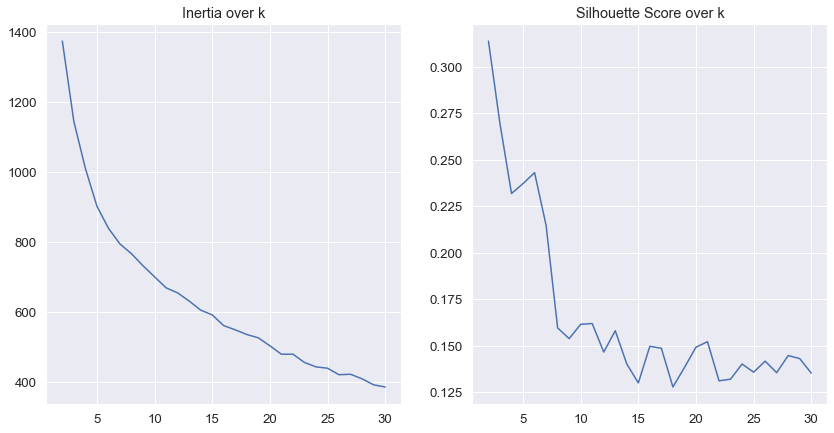

In [506]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].plot(score_df.k, score_df.inertia)
axes[0].set_title('Inertia over k')
axes[1].plot(score_df.k, score_df.silhouette);
axes[1].set_title('Silhouette Score over k')

### Gaussian Mixtures:

In [507]:
# Instantiate and Fit Gaussian Mixture: 

gm = GaussianMixture(n_components=6, random_state = 42)
gm.fit(X_sc)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=6, n_init=1, precisions_init=None,
                random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [508]:
# Map cluster label back to dataframe:

labels = gm.predict(X_sc) 
df['gm_cluster'] = labels 

In [509]:
df['gm_cluster'].value_counts(normalize=True)

1    0.299435
5    0.237288
2    0.209040
4    0.152542
3    0.079096
0    0.022599
Name: gm_cluster, dtype: float64

In [510]:
# Print the converged log-likelihood value:

print(gm.lower_bound_) 

-6.567538832783286


In [511]:
# Print the number of iterations needed for the log-likelihood value to converge:

print(gm.n_iter_)

8


In [512]:
# GMM sil score:

silhouette_score(X_sc, df['gm_cluster'])

0.2343343066304416

In [513]:
# Programmaticaly search for best number of clusters:

scores = []
for g in range(2, 31):
    gm = GaussianMixture(n_components=g)
    gm.fit(X_sc)
    #inertia = gm.inertia_
    sil = silhouette_score(X_sc, gm.predict(X_sc))
    scores.append([g, sil])
    
score_df = pd.DataFrame(scores)
score_df.columns = ['g', 'silhouette']

print(score_df.head())

   g  silhouette
0  2    0.307971
1  3    0.268048
2  4    0.210876
3  5    0.224475
4  6    0.205884


## Map Clusters:

In [514]:
# Import shapefile:

shp = gpd.read_file('../data/spatial_data/dc_census_tracts_2018.shp')

In [515]:
# Convert geo_id shp column to numeric:

shp['geo_id'] = shp['GEOID']
shp[['geo_id']] = shp[['geo_id']].apply(pd.to_numeric)

In [516]:
shp.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   OBJECTID  179 non-null    int64   
 1   GEOID     179 non-null    object  
 2   NAME      179 non-null    object  
 3   geometry  179 non-null    geometry
 4   geo_id    179 non-null    int64   
dtypes: geometry(1), int64(2), object(2)
memory usage: 7.1+ KB


In [517]:
# Merge on shared variable (geo_id):

census_tracts = shp.merge(df, on='geo_id')

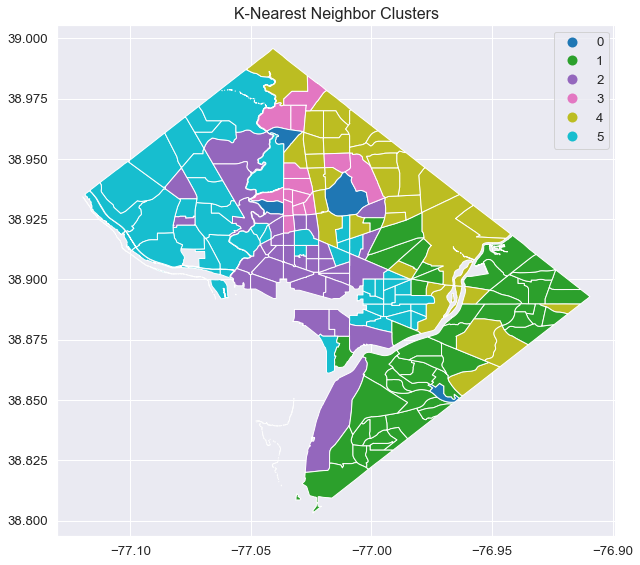

In [518]:
# Map KNN Clusters:

census_tracts.plot(figsize=(10,10),
         column=census_tracts['knn_cluster'],
         categorical = True,
         legend=True)
plt.title('K-Nearest Neighbor Clusters', fontsize=16);

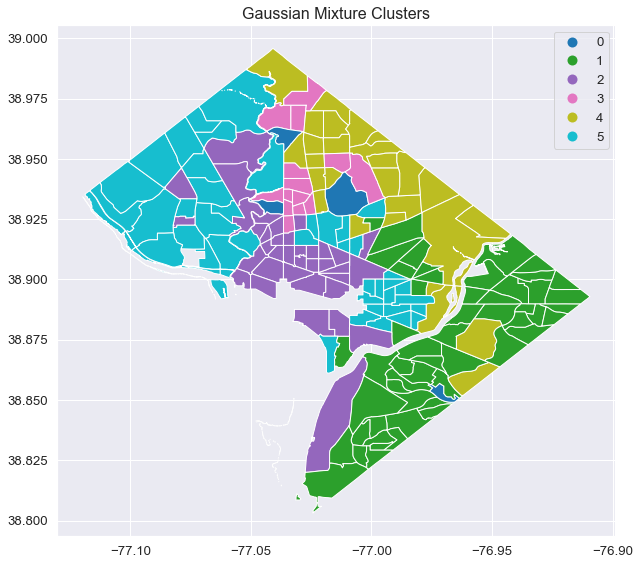

In [520]:
# Map GMM Clusters:

census_tracts.plot(figsize=(10,10),
         column=census_tracts['gm_cluster'],
         categorical = True,
         legend=True)
plt.title('Gaussian Mixture Clusters', fontsize=16);

## Investigate Clusters:

In [521]:
# Create df of scaled values:

X_scaled = pd.DataFrame(X_sc)

# Map cluster label back to dataframe:

X_scaled['gm_cluster'] = labels 
X_scaled['knn_cluster'] = km.labels_

In [523]:
X_scaled.groupby('knn_cluster').mean().T[[0,1,2,3,4,5]]

knn_cluster,0,1,2,3,4,5
0,0.383927,-0.460216,-0.468604,-0.441777,0.841782,0.387533
1,0.633537,-0.787275,0.156229,2.437953,0.071537,-0.135958
2,-0.023271,1.193930,-0.819617,-0.310139,0.551094,-1.000371
3,-0.207855,-0.807047,1.222350,-0.124270,-0.474848,0.337893
4,-0.186651,1.240350,-0.587925,-0.343734,-0.068728,-0.754456
5,0.365102,0.808995,-0.975866,0.359816,0.360477,-0.546943
6,-0.629488,-1.092931,0.232238,-0.312683,-0.027253,1.237044
7,0.349818,0.381795,-1.185982,0.491429,0.745531,-0.217089
8,-0.384709,-1.225435,0.819421,-0.237013,-0.307970,1.071596
9,-0.022310,-0.932238,0.704497,-0.422651,-0.449669,0.963210


In [524]:
df.groupby('knn_cluster').mean().T[[0,1,2,3,4,5]]

knn_cluster,0,1,2,3,4,5
Unnamed: 0,5.000000e+01,1.244082e+02,8.074286e+01,5.557143e+01,9.887500e+01,5.841860e+01
geo_id,1.100100e+10,1.100101e+10,1.100101e+10,1.100100e+10,1.100101e+10,1.100100e+10
median_age,3.707500e+01,3.231020e+01,3.226286e+01,3.241429e+01,3.965938e+01,3.709535e+01
pct_hisp_latino,1.547500e+01,3.497959e+00,1.145143e+01,3.068571e+01,1.073750e+01,8.988372e+00
pct_black,4.850000e+01,8.993061e+01,2.139429e+01,3.873571e+01,6.805000e+01,1.524186e+01
pct_asian,2.725000e+00,6.000000e-01,7.797143e+00,3.021429e+00,1.778125e+00,4.660465e+00
pct_unemployed,4.900000e+00,1.061020e+01,3.294286e+00,4.271429e+00,5.371875e+00,2.627907e+00
avg_wrk_commute_mins,3.325000e+01,3.564898e+01,2.600286e+01,3.322143e+01,3.322500e+01,2.832093e+01
median_hsld_income,5.840150e+04,3.703155e+04,9.813677e+04,7.300979e+04,8.617134e+04,1.444697e+05
avg_household_size,2.565000e+00,2.580000e+00,1.844571e+00,2.631429e+00,2.750625e+00,2.299070e+00


In [537]:
# Create dataframe for radar/spider plots:

X_scaled_radar = pd.DataFrame(X_scaled.groupby('gm_cluster').mean().T[[0,1,2,3,4,5]])

X_scaled_radar = X_scaled_radar.T

X_scaled_radar = X_scaled_radar.rename(columns={11 : 'pct_renter_occupied',
                                                10 : 'pct_other_minority',
                                                9  : 'median_rent',
                                                8  : 'pct_bach_degree',
                                                7  : 'avg_household_size',
                                                6  : 'median_hsld_income',
                                                5  : 'avg_wrk_commute_mins',
                                                4  : 'pct_unemployed',
                                                3  : 'pct_asian',
                                                2  : 'pct_black',
                                                1  : 'pct_hisp_latino',
                                                0  : 'median_age'
                                               })

X_scaled_radar.columns

Index(['median_age', 'pct_hisp_latino', 'pct_black', 'pct_asian',
       'pct_unemployed', 'avg_wrk_commute_mins', 'median_hsld_income',
       'avg_household_size', 'pct_bach_degree', 'median_rent',
       'pct_other_minority', 'pct_renter_occupied', 'knn_cluster'],
      dtype='object')

In [538]:
# Drop KNN Cluster ID from Data Frame:

X_scaled_radar = X_scaled_radar.drop(columns='knn_cluster')

X_scaled_radar

,median_age,pct_hisp_latino,pct_black,pct_asian,pct_unemployed,avg_wrk_commute_mins,median_hsld_income,avg_household_size,pct_bach_degree,median_rent,pct_other_minority,pct_renter_occupied
gm_cluster,,,,,,,,,,,,
0,0.383927,0.633537,-0.023271,-0.207855,-0.186651,0.365102,-0.629488,0.349818,-0.384709,-0.022310,4.426237,0.493674
1,-0.357732,-0.801134,1.187654,-0.808111,1.162358,0.780731,-1.056014,0.397481,-1.201194,-0.934282,-0.198328,0.572078
2,-0.358599,0.159426,-0.882416,1.198769,-0.593927,-0.933386,0.315846,-1.205522,0.857772,0.754720,0.186385,0.669225
3,-0.441777,2.437953,-0.310139,-0.124270,-0.343734,0.359816,-0.312683,0.491429,-0.237013,-0.422651,-0.243109,0.604131
4,0.951996,0.246788,0.477700,-0.440483,-0.089467,0.362019,0.053668,0.767885,-0.242960,-0.360735,-0.009976,-1.237440
5,0.266030,-0.161129,-0.922836,0.308087,-0.753695,-0.550375,1.184021,-0.130342,1.031968,0.889012,-0.248022,-0.764360


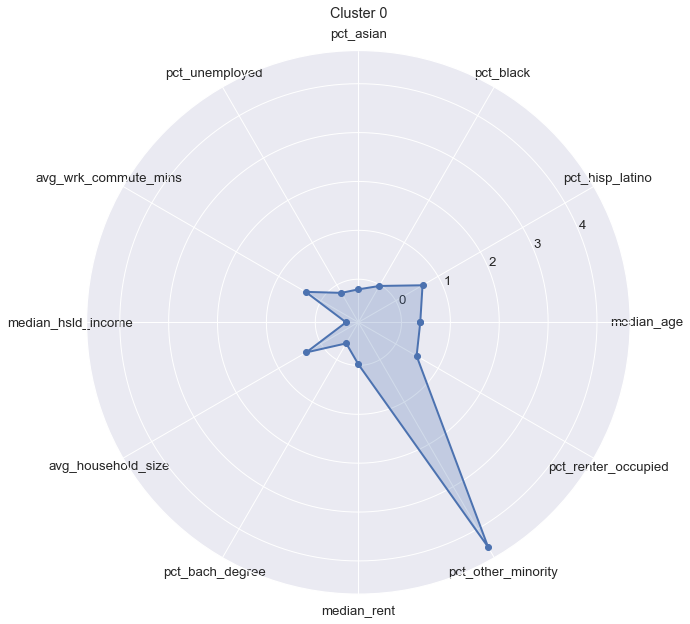

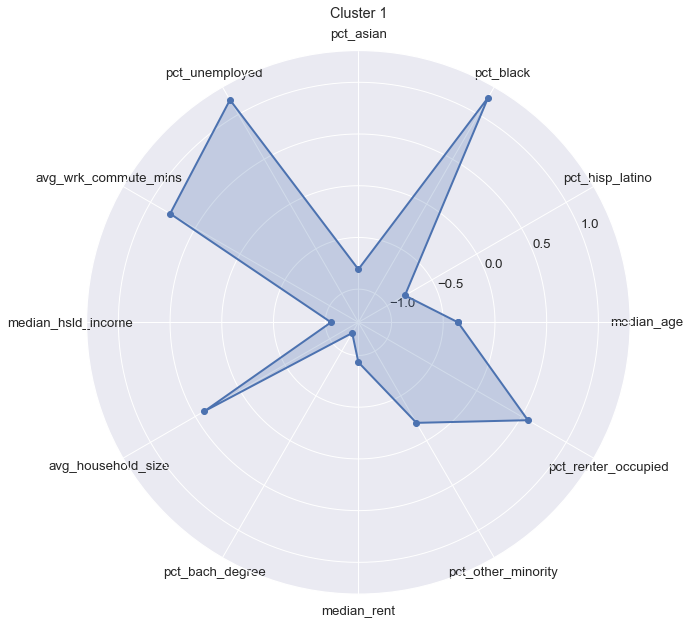

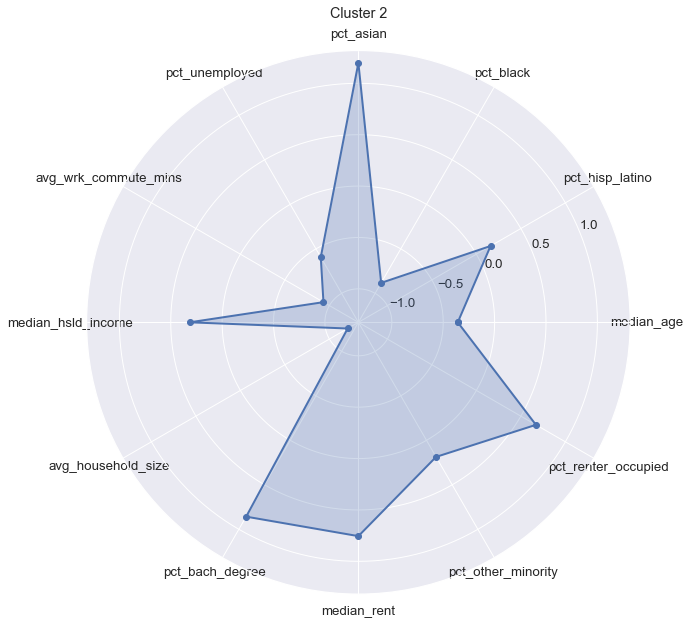

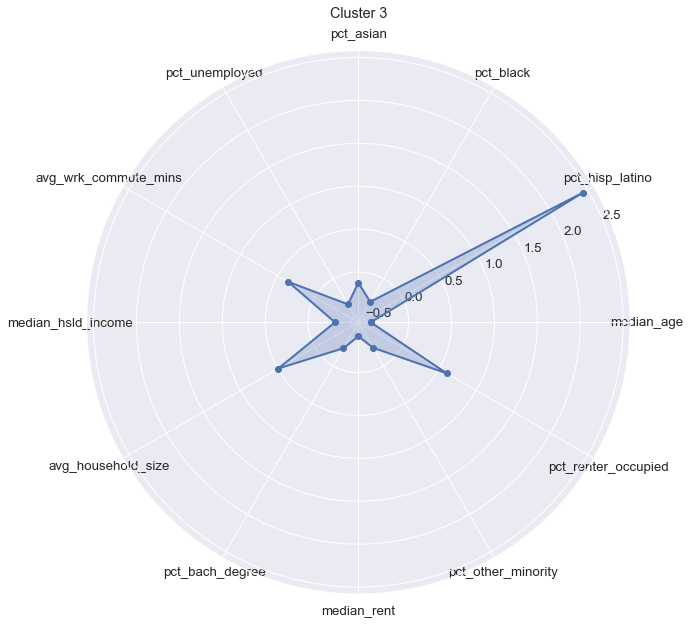

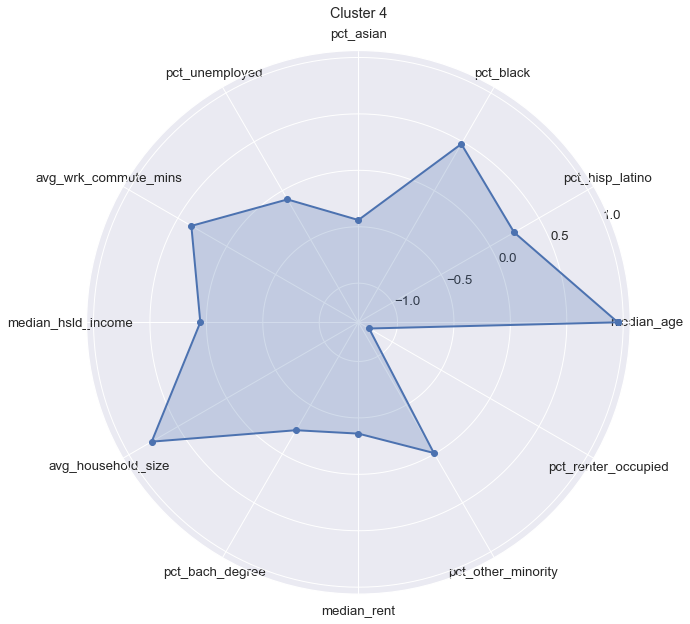

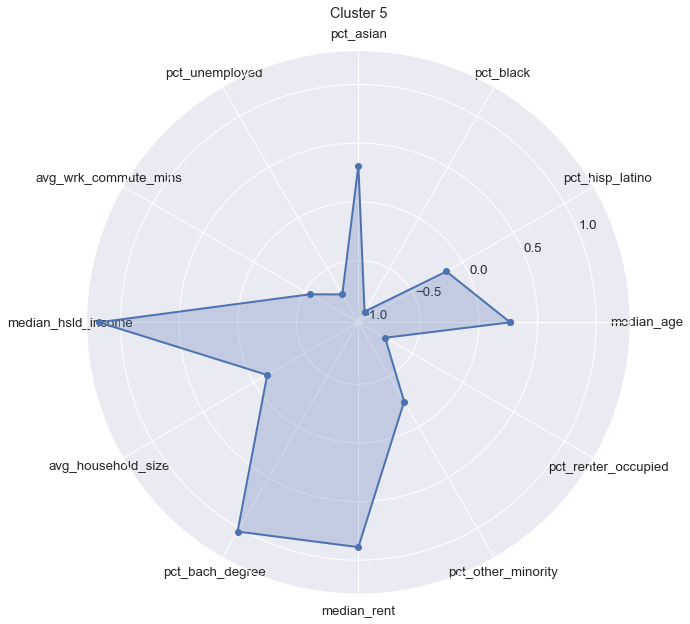

In [540]:
# Radar/Spider Plot of Clusters:

for i in range (6):
    labels=np.array(['median_age',
                     'pct_hisp_latino',
                     'pct_black',
                     'pct_asian',
                     'pct_unemployed',
                     'avg_wrk_commute_mins',
                     'median_hsld_income',
                     'avg_household_size',
                     'pct_bach_degree',
                     'median_rent',
                     'pct_other_minority',
                     'pct_renter_occupied'])
    zscores=np.array(X_scaled_radar.loc[i,labels].values)
    angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    
    # close the plot
    zscores=np.concatenate((zscores,[zscores[0]]))
    angles=np.concatenate((angles,[angles[0]]))

    fig=plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, zscores, 'o-', linewidth=2)
    ax.fill(angles, zscores, alpha=0.25)
    ax.set_thetagrids(angles * 180/np.pi, labels)
    ax.set_title(f'Cluster {i}')
    ax.grid(True)

## Export Data:

In [549]:
# Export Dataframe with combined scores for Tableau:

census_tracts.to_csv('../data/outputs/04_clustered_census_tracts.csv', index=False)

In [552]:
# Export Data as Shapefile for Tableau:

census_tracts.to_file('../data/outputs/04_clustered_census_tracts.shp')

In [550]:
# Export Cluster means table: 

X_scaled_radar.to_csv('../data/outputs/05_gmm_cluster_means.csv')

## Thoughts and Next Steps:

In [ ]:
# How do we desccribe each cluster? 
# 
# PCA on original data and cluster the components
#